# Exploratory data analysis 
## Merging pandemic statistics and sentiment

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Here we join two sources:

In [6]:
df1 = pd.read_csv('../../data/sentimentsUS.csv',sep=',')
df2 = pd.read_csv('../../data/covidDataUS.csv',sep=',')
df = pd.merge(df1[['day','sentiment','negPercentage','posPercentage']], df2, left_on='day', right_on='date', how='inner')
df.head() 

,day,sentiment,negPercentage,posPercentage,date,death,deathIncrease,inIcuCumulative,inIcuCurrently,hospitalizedIncrease,...,hospitalizedCumulative,negative,negativeIncrease,onVentilatorCumulative,onVentilatorCurrently,positive,positiveIncrease,states,totalTestResults,totalTestResultsIncrease
0,2020-02-11,1,NaN,NaN,2020-02-11,0.0,0,NaN,NaN,0,...,NaN,NaN,0,NaN,NaN,5.0,0,5,20,1
1,2020-02-12,1,1.000000,NaN,2020-02-12,0.0,0,NaN,NaN,0,...,NaN,NaN,0,NaN,NaN,5.0,0,5,21,1
2,2020-02-13,3,0.333333,0.333333,2020-02-13,0.0,0,NaN,NaN,0,...,NaN,NaN,0,NaN,NaN,6.0,1,5,22,1
3,2020-02-14,1,1.000000,NaN,2020-02-14,0.0,0,NaN,NaN,0,...,NaN,NaN,0,NaN,NaN,7.0,1,5,22,0
4,2020-02-15,1,NaN,NaN,2020-02-15,0.0,0,NaN,NaN,0,...,NaN,NaN,0,NaN,NaN,7.0,0,6,26,4


Following steps are used to explore the data

In [7]:
df.shape
df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390 entries, 0 to 389
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   day                       390 non-null    object 
 1   sentiment                 390 non-null    int64  
 2   negPercentage             385 non-null    float64
 3   posPercentage             384 non-null    float64
 4   date                      390 non-null    object 
 5   death                     390 non-null    float64
 6   deathIncrease             390 non-null    int64  
 7   inIcuCumulative           348 non-null    float64
 8   inIcuCurrently            347 non-null    float64
 9   hospitalizedIncrease      390 non-null    int64  
 10  hospitalizedCurrently     356 non-null    float64
 11  hospitalizedCumulative    369 non-null    float64
 12  negative                  372 non-null    float64
 13  negativeIncrease          390 non-null    int64  
 14  onVentilat

In [8]:
df.columns.values 

array(['day', 'sentiment', 'negPercentage', 'posPercentage', 'date',
       'death', 'deathIncrease', 'inIcuCumulative', 'inIcuCurrently',
       'hospitalizedIncrease', 'hospitalizedCurrently',
       'hospitalizedCumulative', 'negative', 'negativeIncrease',
       'onVentilatorCumulative', 'onVentilatorCurrently', 'positive',
       'positiveIncrease', 'states', 'totalTestResults',
       'totalTestResultsIncrease'], dtype=object)

Summary statistics

In [9]:
df.describe() 

,sentiment,negPercentage,posPercentage,death,deathIncrease,inIcuCumulative,inIcuCurrently,hospitalizedIncrease,hospitalizedCurrently,hospitalizedCumulative,negative,negativeIncrease,onVentilatorCumulative,onVentilatorCurrently,positive,positiveIncrease,states,totalTestResults,totalTestResultsIncrease
count,390.000000,385.000000,384.000000,390.000000,390.000000,348.000000,347.000000,390.000000,356.000000,369.000000,3.720000e+02,390.000000,341.000000,348.000000,3.900000e+02,390.000000,390.000000,3.900000e+02,3.900000e+02
mean,153.261538,0.230356,0.292644,188170.723077,1320.900000,21059.344828,12059.227666,1990.669231,57987.117978,310817.140921,3.030351e+07,191238.012821,2173.932551,3975.298851,8.720235e+06,73734.574359,53.066667,1.155936e+08,9.328849e+05
std,101.216068,0.079370,0.065394,142061.035772,1052.875677,13572.638376,5668.415483,1691.200202,31898.555998,235557.870159,2.407815e+07,115296.877380,1327.372196,2191.080602,9.007394e+06,68496.036759,11.243080,1.130342e+08,6.355752e+05
min,1.000000,0.083333,0.119048,0.000000,0.000000,74.000000,1299.000000,-2858.000000,325.000000,4.000000,2.000000e+00,-658774.000000,32.000000,167.000000,5.000000e+00,0.000000,5.000000,2.000000e+01,0.000000e+00
25%,88.000000,0.189135,0.259389,88800.750000,608.750000,9900.250000,7495.500000,989.500000,35100.500000,123250.000000,6.753778e+06,121016.000000,951.000000,2168.500000,1.536822e+06,26002.000000,56.000000,1.302087e+07,3.971675e+05
50%,123.500000,0.224066,0.291274,169859.000000,1068.500000,18797.500000,10114.000000,1556.000000,48811.000000,280138.000000,2.757246e+07,214960.500000,2107.000000,3186.500000,5.712982e+06,47592.000000,56.000000,8.085720e+07,8.760285e+05
75%,192.750000,0.258065,0.319719,259430.750000,1759.500000,32998.500000,15596.500000,2622.000000,70519.250000,481309.000000,5.084301e+07,263904.500000,3430.000000,5828.500000,1.350360e+07,102070.250000,56.000000,1.980925e+08,1.449095e+06
max,498.000000,1.000000,1.000000,515151.000000,5427.000000,45475.000000,23912.000000,17155.000000,132474.000000,776361.000000,7.458282e+07,480256.000000,4281.000000,8004.000000,2.875649e+07,295121.000000,56.000000,3.638251e+08,2.309884e+06


Visual analysis

<AxesSubplot:>

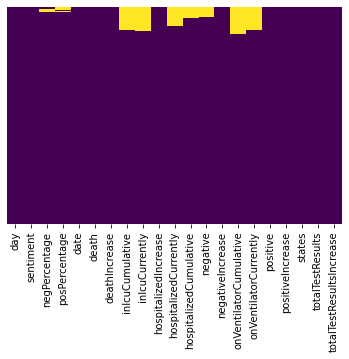

In [10]:
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap = 'viridis')

Check correlation

<AxesSubplot:>

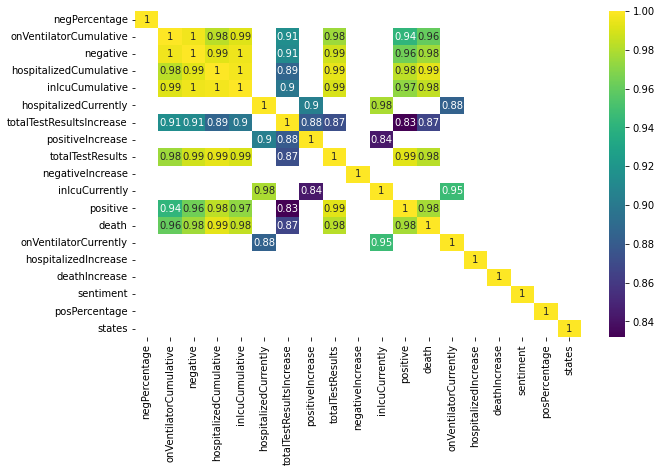

In [17]:
#Quality correlation matrix
k = 21 #number of variables for heatmap
cols = df.corr().nlargest(k, 'negPercentage')['negPercentage'].index
cm = df[cols].corr()
highCorrelationCM = cm[cm > 0.8]
plt.figure(figsize=(10,6))
sns.heatmap(highCorrelationCM, annot=True, cmap = 'viridis')

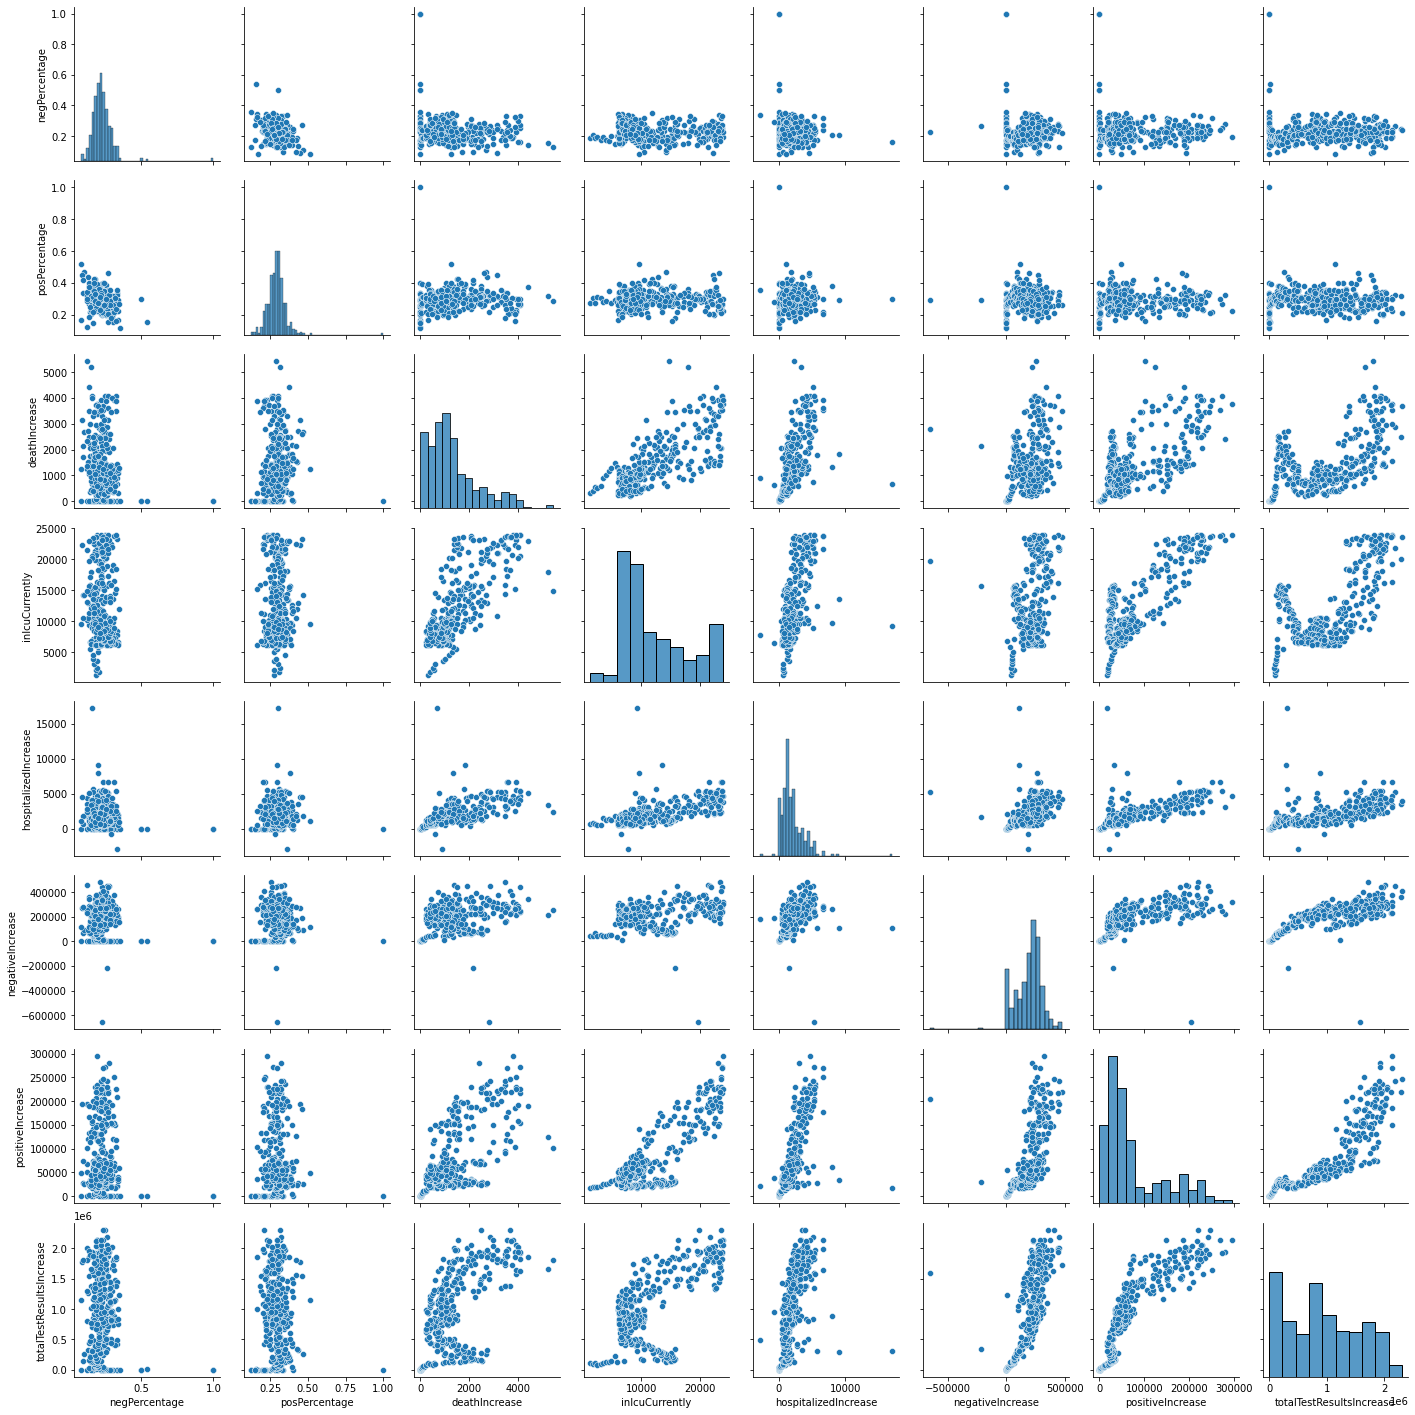

In [12]:
sns.pairplot(df[['negPercentage', 'posPercentage','deathIncrease','inIcuCurrently',
       'hospitalizedIncrease', 'negativeIncrease',
       'positiveIncrease', 'totalTestResultsIncrease']])
plt.show()